<a href="https://colab.research.google.com/github/danieladoghe/AI-projects-/blob/main/Sentiment_Analysis_of_Netflix_data_with_collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357298 sha256=447768733e65e6456306ed856e731a3d541812bdc2bd504968e2118457f4e377
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Precision, Recall, Accuracy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from surprise import SVD, Dataset, Reader # This should now import without error
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, mean_absolute_error



In [ ]:
# Load the dataset
file_path = '/content/netflix_titles.csv'
netflix_data = pd.read_csv(file_path)

In [ ]:
# Data Cleaning: Fill missing values with appropriate defaults or the mode
netflix_data['director'].fillna('Unknown', inplace=True)
netflix_data['cast'].fillna('Unknown', inplace=True)
netflix_data['country'].fillna('Unknown', inplace=True)
netflix_data['date_added'].fillna(netflix_data['date_added'].mode()[0], inplace=True)
netflix_data['rating'].fillna(netflix_data['rating'].mode()[0], inplace=True)
netflix_data['duration'].fillna(netflix_data['duration'].mode()[0], inplace=True)


In [ ]:
# Filter for movies only (assuming duration contains 'min')
movies_only = netflix_data[netflix_data['type'] == 'Movie']
movies_only = movies_only[movies_only['duration'].str.contains(' min')]
movies_only['duration'] = movies_only['duration'].str.replace(' min', '').astype(int)


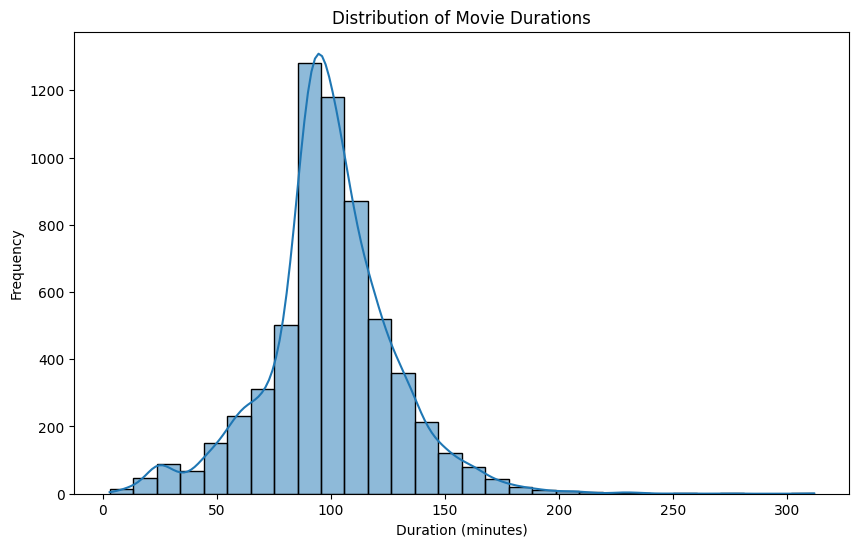

In [ ]:
# Exploratory Data Analysis: Visualization of movie durations
plt.figure(figsize=(10, 6))
sns.histplot(movies_only['duration'], bins=30, kde=True)
plt.title('Distribution of Movie Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

<ipython-input-7-cf33fcbc1dc6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 0], x='type', data=netflix_data, palette='viridis')
<ipython-input-7-cf33fcbc1dc6>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1, 1], y=top_countries.index, x=top_countries.values, palette='spring')
<ipython-input-7-cf33fcbc1dc6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_shows['num_seasons'] = tv_shows['duration'].str.extract('(\d+)')

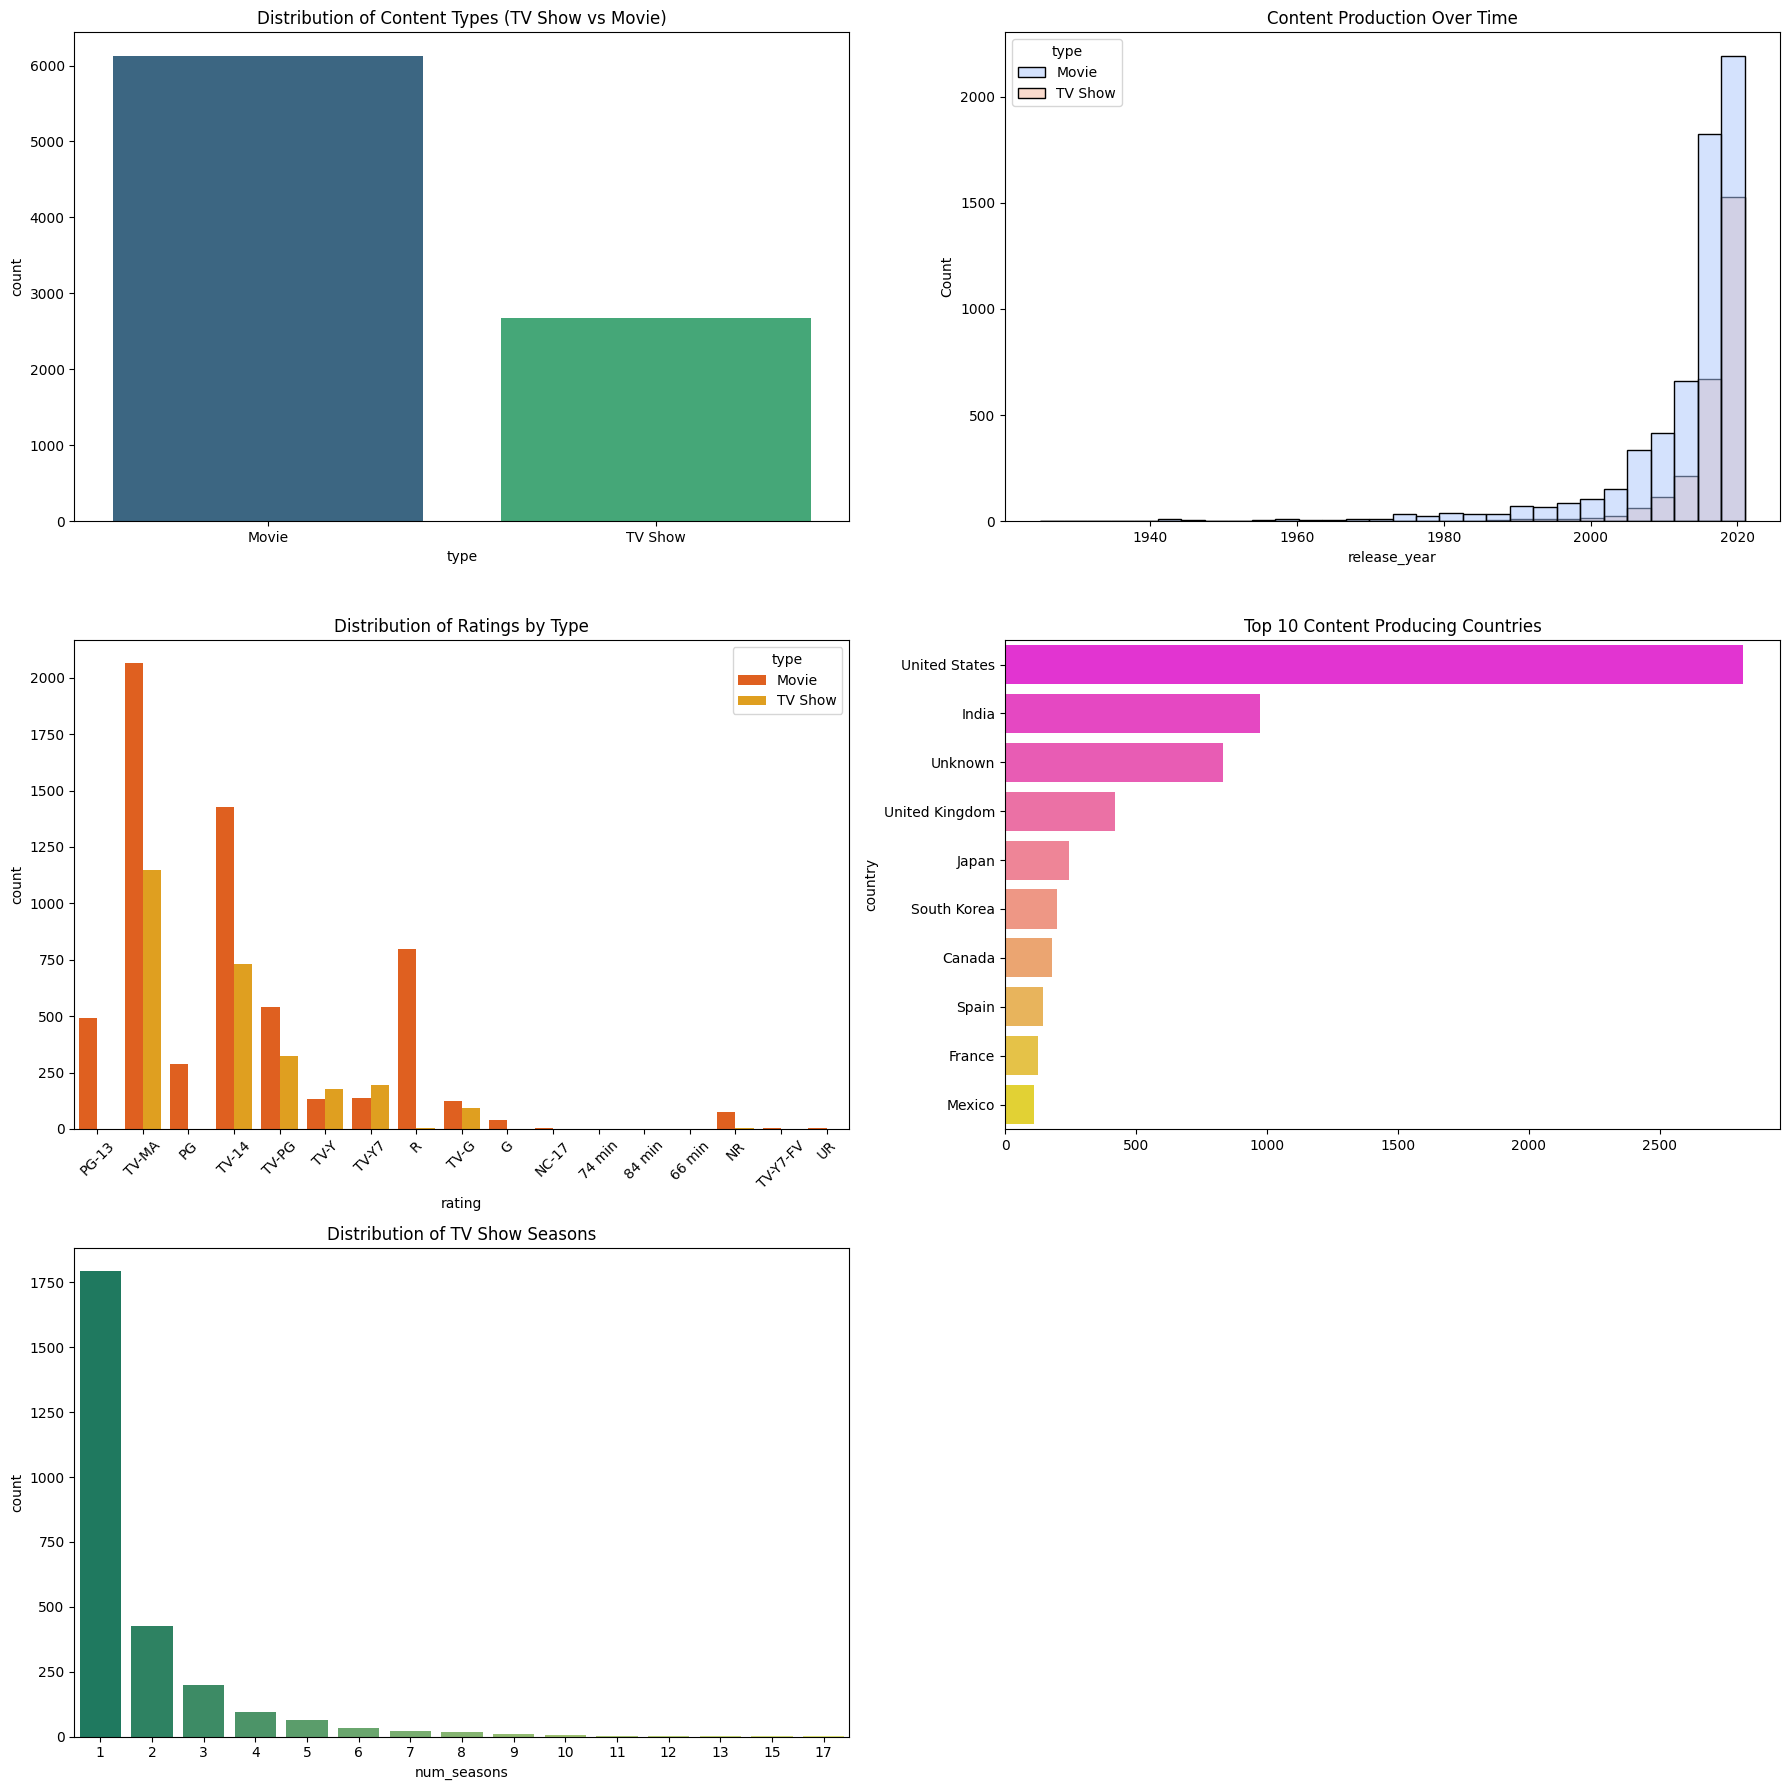

In [ ]:
# Figure setup for multiple plots
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
fig.delaxes(axes[2][1])  # Remove the unused subplot

# 1. Distribution of TV Shows vs. Movies
sns.countplot(ax=axes[0, 0], x='type', data=netflix_data, palette='viridis')
axes[0, 0].set_title('Distribution of Content Types (TV Show vs Movie)')

# 2. Content Production Over Time
sns.histplot(ax=axes[0, 1], data=netflix_data, x='release_year', bins=30, kde=False, hue='type', palette='coolwarm')
axes[0, 1].set_title('Content Production Over Time')

# 3. Ratings Distribution
sns.countplot(ax=axes[1, 0], data=netflix_data, x='rating', hue='type', palette='autumn')
axes[1, 0].set_title('Distribution of Ratings by Type')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Top Content-Producing Countries
top_countries = netflix_data['country'].value_counts().head(10)
sns.barplot(ax=axes[1, 1], y=top_countries.index, x=top_countries.values, palette='spring')
axes[1, 1].set_title('Top 10 Content Producing Countries')

# 5. Duration Analysis for TV Shows (number of seasons)
tv_shows = netflix_data[netflix_data['type'] == 'TV Show']
tv_shows['num_seasons'] = tv_shows['duration'].str.extract('(\d+)').astype(int)
sns.countplot(ax=axes[2, 0], x='num_seasons', data=tv_shows, palette='summer')
axes[2, 0].set_title('Distribution of TV Show Seasons')

plt.tight_layout()
plt.show()

In [ ]:
# Feature Engineering for Sentiment Analysis: Preprocessing Text
def preprocess_text(data):
    data = data.str.replace("[^a-zA-Z]", " ", regex=True).str.lower()
    return data

In [ ]:
movies_only = netflix_data[netflix_data['type'] == 'Movie'].copy()
simplified_processed_descriptions = preprocess_text(movies_only['description'])

In [ ]:
# Vectorizing the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Limiting to top 1000 features
tfidf_matrix = tfidf_vectorizer.fit_transform(simplified_processed_descriptions)


In [ ]:
# Prepare for using advanced NLP models (Outline)

from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
movies_only['sentiment'] = movies_only['description'].apply(lambda x: sentiment_pipeline(x)[0])
movies_only['sentiment_label'] = movies_only['sentiment'].apply(lambda x: x['label'])
movies_only['sentiment_score'] = movies_only['sentiment'].apply(lambda x: x['score'])


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
# Convert 'sentiment_label' to numeric for model integration
sentiment_mapping = {'POSITIVE': 1, 'NEGATIVE': 0}
movies_only['sentiment_numeric'] = movies_only['sentiment_label'].map(sentiment_mapping)

In [ ]:
# Simulate user data
np.random.seed(42)
user_ids = np.random.randint(1000, 1100, size=len(movies_only))  # Simulate user IDs for each movie
movie_ids = pd.factorize(movies_only['title'])[0] + 1  # Generate movie IDs

In [ ]:
# Assume that each user rates each movie they've interacted with
ratings = np.random.randint(1, 6, size=len(movies_only))  # Random ratings between 1 and 5

In [ ]:
# Create a new DataFrame for collaborative filtering
collab_df = pd.DataFrame({
    'user_id': user_ids,
    'movie_id': movie_ids,
    'rating': ratings,
    'sentiment_score': movies_only['sentiment_score'].values
})

In [ ]:
# Example of setting up a collaborative filtering model using this data
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate


In [ ]:
# Load the data into Surprise library's format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(collab_df[['user_id', 'movie_id', 'rating']], reader)


In [ ]:
# Model
model = SVD()
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.4394  1.4185  1.4249  1.4276  0.0088  
MAE (testset)     1.2500  1.2299  1.2254  1.2351  0.0107  
Fit time          0.26    0.40    0.26    0.31    0.07    
Test time         0.05    0.03    0.02    0.03    0.02    


{'test_rmse': array([1.43943235, 1.41851501, 1.42489613]),
 'test_mae': array([1.24999389, 1.22991648, 1.22544235]),
 'fit_time': (0.2612874507904053, 0.4010031223297119, 0.2615935802459717),
 'test_time': (0.05323934555053711,
  0.029462337493896484,
  0.015012502670288086)}

In [ ]:
param_grid = {
    'n_epochs': [5, 10, 20],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.4, 0.6]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

In [ ]:
# best RMSE score
print("Best RMSE score obtained: ", gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print("Parameters that give the best RMSE score: ", gs.best_params['rmse'])

Best RMSE score obtained:  1.421466034241994
Parameters that give the best RMSE score:  {'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.6}


In [ ]:
# Train the final model with the best parameters
best_model = gs.best_estimator['rmse']
trainset = data.build_full_trainset()
best_model.fit(trainset)

In [ ]:
# Neural Network Model Preparation
X = collab_df[['sentiment_score']].astype(np.float32)  # Ensure float32 for compatibility
y = collab_df['rating'].astype(np.float32)  # Target: Rating, ensure float32

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define a custom loss function
def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)  # Ensure y_true is float32
    error = y_true - y_pred
    greater = tf.greater(error, 0)
    loss = tf.where(greater, 2.0 * tf.square(error), tf.square(error))
    return tf.reduce_mean(loss, axis=-1)

In [ ]:
model_nn = Sequential([
    Dense(10, activation='relu', input_dim=1),
    Dense(1, activation='sigmoid')
])
model_nn.compile(optimizer='adam', loss='mean_squared_error', metrics=[Precision(), Recall()])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
model_nn.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.5640 - precision: 1.0000 - recall: 1.0000
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7729 - precision: 1.0000 - recall: 1.0000
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3571 - precision: 1.0000 - recall: 1.0000
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2262 - precision: 1.0000 - recall: 1.0000
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0777 - precision: 1.0000 - recall: 1.0000
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0629 - precision: 1.0000 - recall: 1.0000
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0203 - precision: 1.0000 - recall: 1.0000
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9959 - precision: 1.0000 - recall: 1.0000
Epoch 9/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9405 - precision: 1.0000 - recall: 1.0000
Epoch 10/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Assuming `y_true` holds the actual ratings or classes and `y_pred` holds the predicted ratings or classes
# Both should be of the same length and have the actual and predicted labels respectively

# Example data (replace these with your actual data)
y_true = [1, 0, 1, 1, 0, 1, 0, 1, 0, 1]  # actual values
y_pred = [1, 0, 1, 1, 1, 0, 0, 1, 0, 0]  # predicted values

# Calculate Accuracy: (TP + TN) / (TP + TN + FP + FN)
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate Precision: TP / (TP + FP)
# Precision is calculated for the positive class, which is defined as the label '1' here.
precision = precision_score(y_true, y_pred, pos_label=1)  # Ensure you define the positive class correctly
print(f"Precision: {precision}")

# Calculate Recall: TP / (TP + FN)
# Recall is also calculated for the positive class.
recall = recall_score(y_true, y_pred, pos_label=1)
print(f"Recall: {recall}")

# Optional: Calculate confusion matrix to see TP, TN, FP, FN
conf_matrix = confusion_matrix(y_true, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.7
Precision: 0.8
Recall: 0.6666666666666666
Confusion Matrix:
[[3 1]
 [2 4]]


In [ ]:
y_pred = model_nn.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 6.032696723937988
Mean Absolute Error (MAE): 2.0010299682617188


In [ ]:
# Calculate additional metrics (accuracy, precision, recall) for binary classification
# Thresholding predictions to binary classes if needed
threshold = 0.5
y_pred_classes = (y_pred >= threshold).astype(int)
y_test_classes = (y_test >= threshold).astype(int)

In [ ]:
#NEW CODE